**Author:** Sydney Crandall

**Last Edited:** June 1st, 2022

In [1]:
# imports
import pandas as pd
import numpy as np
import cluster
import math
import munge
import datetime as dt
from metpy.units import units
import visualizations as vis
from scipy.stats import iqr
import matplotlib.pyplot as plt
import seaborn as sb
import gapstat as gs

In [2]:
# run functions from munge.py
bil = munge.from_raw("BillingsRaw.csv")
bil = munge.add_season_rearrange(bil)
bil = munge.replace_month_hour(bil)
bil = munge.wet_bulb(bil)
bilHourly = munge.to_hourly(bil)
bilDaily = munge.to_daily(bilHourly)

bilHourly.to_csv("billingsHourly.csv")
bilDaily.to_csv("billingsDaily.csv")

In [3]:
bilHourly.columns

Index(['datetime', 'drytemp_F', 'dewtemp_F', 'wetbulb_F', 'RH', 'pres_mbar',
       'wdir', 'wspd_mph', 'wgust_mph', 'prec_inch', 'hour', 'month',
       'tilt_season'],
      dtype='object')

In [4]:
# run functions from cluster.py
included_cols = ['drytemp_F','dewtemp_F', 'wetbulb_F','RH','pres_mbar','wdir','wspd_mph','wgust_mph',"prec_inch"]
bilSelect = cluster.select_time(bilHourly,12)
bilData, bilScaledData = cluster.scale_and_convert_to_numpy(bilSelect, included_cols)
bilSelect.to_csv("bilNoon.csv")

#init_centroids = cluster.plus_plus(albScaledData, 4)
init_centroids = 3
bilCentroids, bilIdx = cluster.cluster_data(init_centroids, bilScaledData)

clustering is very good for:
- drytemp, wetbulb, RH, dewtemp, prec_inch
    - including the precip over one hour may not be beneficial, this may be more useful in the daily dataset

clustering starts to get messy for:
- precip_type (wetbulb temperature is a good enough proxy for this column)
- wspd_mph
- wgust_mph (there's often a lot of missing info for this one, so it might be a good idea to not include anyway)
- pres_mbar (there are 2 clusters where the only real difference is pres_mbar

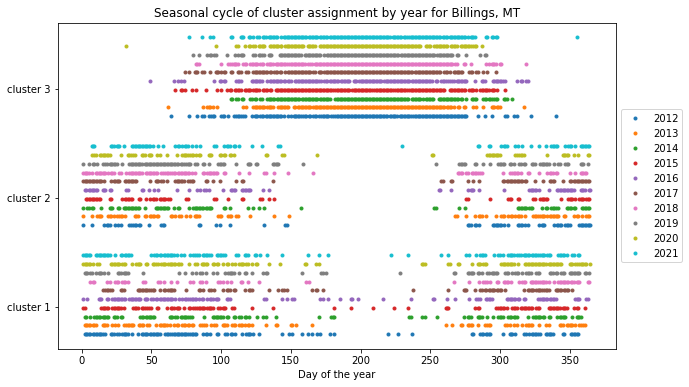

In [5]:
# run functions from visualizations.py
cluster_label_list = ["cluster 1", "cluster 2", "cluster 3", "cluster 4"]
vis.seasonal_assignment_by_year("Billings, MT", cluster_label_list[0:3], 3, bilSelect, bilIdx)

In [6]:
centroidsScaledDF = pd.DataFrame(bilCentroids, columns = included_cols)

In [7]:
centroidsDF = pd.DataFrame(bilData, columns = included_cols).describe().loc["std"]*centroidsScaledDF

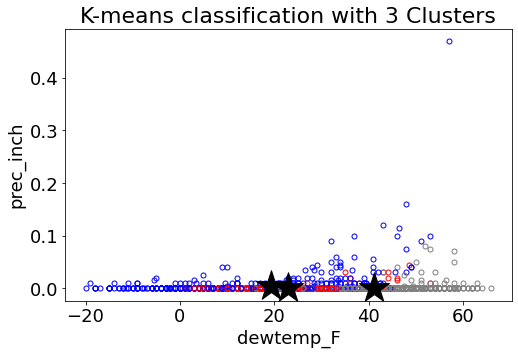

In [8]:
vis.variable_scatter_plots("dewtemp_F", "prec_inch", included_cols, 3, bilIdx, bilData, centroidsDF.to_numpy())

# red: 1
# blue: 2
# grey: 3
# orange/yellow: 4

In [9]:
centroidsDF

,drytemp_F,dewtemp_F,wetbulb_F,RH,pres_mbar,wdir,wspd_mph,wgust_mph,prec_inch
0,51.417794,22.939481,39.228356,35.609110,889.059904,263.903613,18.100218,30.838232,0.000227
1,29.058255,19.322219,25.582315,68.949047,892.665433,130.712535,8.887641,30.015222,0.003598
2,74.936007,41.119597,56.206852,32.822508,891.269679,149.110871,8.252727,23.885881,0.000387


Statistics by cluster

In [10]:
bilSelect["cluster"] = bilIdx

C:\Users\Sydney\AppData\Local\Temp/ipykernel_22376/1501284339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bilSelect["cluster"] = bilIdx


In [11]:
clusterGroups = bilSelect.groupby("cluster")
cluster1 = clusterGroups.get_group(1).reset_index(drop = True)
cluster1Stats = cluster1.describe()
cluster1Stats

,drytemp_F,dewtemp_F,wetbulb_F,RH,pres_mbar,wdir,wspd_mph,wgust_mph,prec_inch,hour,month,tilt_season,cluster
count,1134.00000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.0,1134.000000,1134.000000,1134.0
mean,51.15873,22.752205,39.047176,35.666225,888.942688,263.845673,18.167549,30.888449,0.000229,12.0,6.227513,2.212522,1.0
std,12.56889,8.592129,8.014616,14.156637,6.552137,45.822578,6.565391,5.135599,0.002403,0.0,4.190236,1.227006,0.0
min,15.00000,-4.000000,12.000000,6.000000,868.000000,30.000000,3.000000,17.000000,0.000000,12.0,1.000000,1.000000,1.0
25%,42.00000,17.000000,33.000000,25.000000,885.000000,232.500000,14.000000,29.000000,0.000000,12.0,2.000000,1.000000,1.0
50%,50.00000,22.000000,39.000000,34.000000,889.000000,250.000000,18.000000,30.000000,0.000000,12.0,4.000000,2.000000,1.0
75%,59.00000,28.000000,44.000000,44.000000,893.000000,300.000000,22.000000,32.000000,0.000000,12.0,11.000000,4.000000,1.0
max,99.00000,53.000000,65.000000,93.000000,908.000000,360.000000,47.000000,64.000000,0.045000,12.0,12.000000,4.000000,1.0


In [12]:
cluster2 = clusterGroups.get_group(2).reset_index(drop = True)
cluster2Stats = cluster2.describe()
cluster2Stats

,drytemp_F,dewtemp_F,wetbulb_F,RH,pres_mbar,wdir,wspd_mph,wgust_mph,prec_inch,hour,month,tilt_season,cluster
count,915.000000,915.000000,915.000000,915.00000,915.000000,915.000000,915.000000,915.000000,915.000000,915.0,915.000000,915.000000,915.0
mean,29.015301,19.314754,25.553553,69.02787,892.563416,130.414215,8.857377,30.012022,0.003617,12.0,6.015301,1.983607,2.0
std,14.178405,13.433718,12.884601,15.54610,6.588967,102.238472,5.012632,2.454485,0.020051,0.0,4.387643,1.207541,0.0
min,-14.000000,-20.000000,-15.000000,21.00000,873.000000,0.000000,0.000000,17.000000,0.000000,12.0,1.000000,1.000000,2.0
25%,20.000000,11.000000,18.000000,58.00000,888.000000,40.000000,6.000000,29.000000,0.000000,12.0,2.000000,1.000000,2.0
50%,31.000000,20.500000,28.000000,70.00000,893.000000,90.000000,8.000000,30.000000,0.000000,12.0,4.000000,2.000000,2.0
75%,40.000000,29.000000,35.000000,81.00000,897.000000,220.000000,13.000000,32.000000,0.000000,12.0,11.000000,2.000000,2.0
max,57.000000,57.000000,57.000000,100.00000,911.000000,360.000000,26.000000,33.000000,0.470000,12.0,12.000000,4.000000,2.0


In [13]:
cluster3 = clusterGroups.get_group(3).reset_index(drop = True)
cluster3Stats = cluster3.describe()
cluster3Stats

,drytemp_F,dewtemp_F,wetbulb_F,RH,pres_mbar,wdir,wspd_mph,wgust_mph,prec_inch,hour,month,tilt_season,cluster
count,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.0,1605.000000,1605.000000,1605.0
mean,74.808411,41.042992,56.115265,32.857323,891.120239,150.065414,8.294393,23.914019,0.000383,12.0,7.018692,3.003738,3.0
std,11.902796,8.773863,6.607219,15.204608,4.979593,91.870667,4.192207,2.994251,0.004188,0.0,1.806651,0.686519,0.0
min,42.000000,9.000000,35.000000,7.000000,868.000000,0.000000,0.000000,16.000000,0.000000,12.0,2.000000,1.000000,3.0
25%,66.000000,35.000000,52.000000,22.000000,888.000000,70.000000,6.000000,21.000000,0.000000,12.0,6.000000,3.000000,3.0
50%,76.000000,41.000000,57.000000,30.000000,892.000000,157.000000,8.000000,24.000000,0.000000,12.0,7.000000,3.000000,3.0
75%,84.000000,48.000000,61.500000,41.000000,895.000000,210.000000,11.000000,26.000000,0.000000,12.0,8.000000,3.000000,3.0
max,105.000000,66.000000,74.000000,96.500000,906.000000,360.000000,23.000000,33.000000,0.080000,12.0,12.000000,4.000000,3.0


In [14]:
#cluster4 = clusterGroups.get_group(4).reset_index(drop = True)
#cluster4Stats = cluster4.describe()
#cluster4Stats
bilDaily.columns

Index(['datetime', 'tilt_season', 'drytemp_max', 'drytemp_min', 'dewtemp_avg',
       'wetbulb_avg', 'RH_max', 'RH_min', 'pres_max', 'pres_min', 'wspd_max',
       'wspd_min', 'wdir_avg', 'prec_inch', 'drytemp_max_hour',
       'drytemp_min_hour', 'prec_max_hour', 'pres_max_hour', 'pres_min_hour',
       'pres_tend'],
      dtype='object')

Cluster Daily dataset

In [15]:
included_cols_daily = ['drytemp_max', 'drytemp_min', 'dewtemp_avg',
                       'RH_max', 'RH_min', 'pres_max', 'pres_min', 'prec_inch',
                       'drytemp_max_hour', 'drytemp_min_hour']
bilDayData, bilDayScaledData = cluster.scale_and_convert_to_numpy(bilDaily, included_cols_daily)

#init_centroids = cluster.plus_plus(albScaledData, 4)
init_centroids = 3
bilDayCentroids, bilDayIdx = cluster.cluster_data(init_centroids, bilDayScaledData)

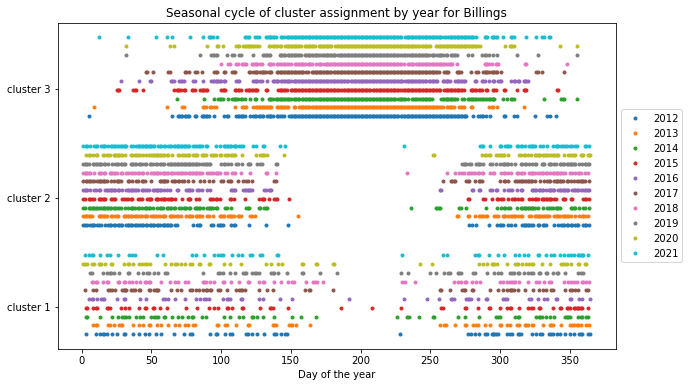

In [16]:
# run functions from visualizations.py
vis.seasonal_assignment_by_year("Billings", cluster_label_list[0:3], 3, bilDaily, bilDayIdx)

In [17]:
centroidsDayScaledDF = pd.DataFrame(bilDayCentroids, columns = included_cols_daily)
centroidsDayDF = pd.DataFrame(bilDayData, columns = included_cols_daily).describe().loc["std"]*centroidsDayScaledDF
centroidsDayDF

,drytemp_max,drytemp_min,dewtemp_avg,RH_max,RH_min,pres_max,pres_min,prec_inch,drytemp_max_hour,drytemp_min_hour
0,44.830929,30.039430,26.017412,84.919519,50.934950,892.836203,884.545595,0.082262,7.776688,19.444490
1,41.269394,23.807641,18.933269,79.086124,44.477403,895.753689,889.373135,0.010491,14.362125,4.230858
2,78.664706,53.410652,39.992945,66.203871,23.898856,893.679609,888.486177,0.009781,14.096798,5.299651


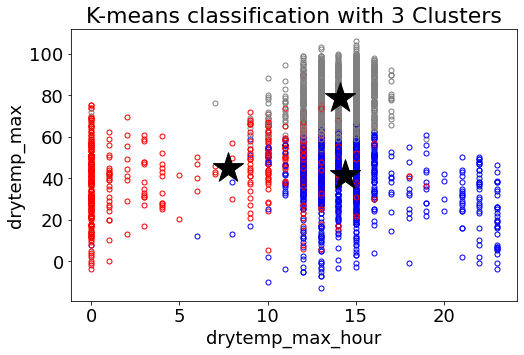

In [18]:
vis.variable_scatter_plots("drytemp_max_hour", "drytemp_max", included_cols_daily, 3, bilDayIdx, bilDayData, centroidsDayDF.to_numpy())

# red: 1
# blue: 2
# grey: 3
# orange/yellow: 4

In [19]:
bilDaily["cluster"] = bilDayIdx
bilDaily["month"] = bilDaily["datetime"].dt.month

In [20]:
clusterMonth = pd.DataFrame()
for clusters in range(1,5):
    dayCount = []
    for months in range(1,13):
        dayCount.append(len(bilDaily.query("cluster == @clusters and month == @months")))
    clusterMonth[clusters] = dayCount
clusterMonth.index = clusterMonth.index + 1
clusterMonth["month"] = clusterMonth.index

<AxesSubplot:xlabel='month', ylabel='3'>

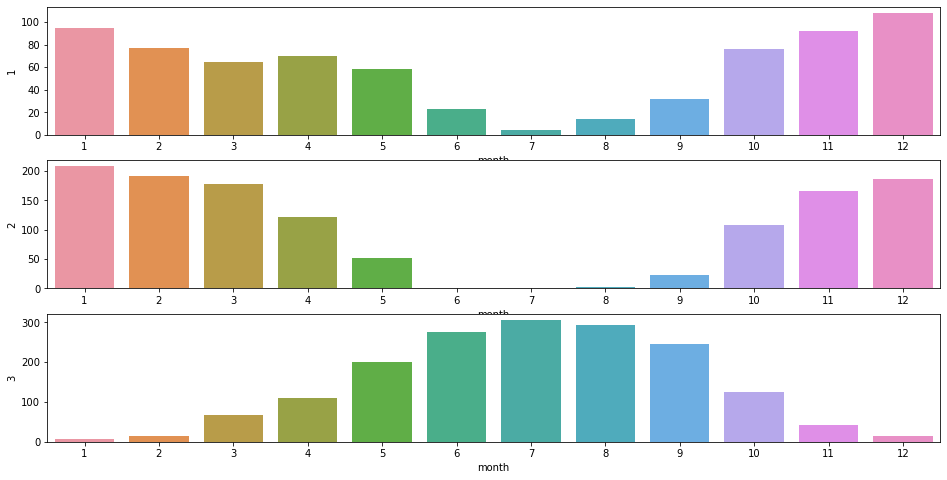

In [21]:
fig, axes = plt.subplots(3, figsize = (16,8))
sb.barplot(x = "month", y = 1, data = clusterMonth, ax = axes[0])
sb.barplot(x = 'month', y = 2, data = clusterMonth, ax = axes[1])
sb.barplot(x = "month", y = 3, data = clusterMonth, ax = axes[2])
#sb.barplot(x = 'month', y = 4, data = clusterMonth, ax = axes[3])

<AxesSubplot:xlabel='drytemp_max_hour', ylabel='drytemp_max'>

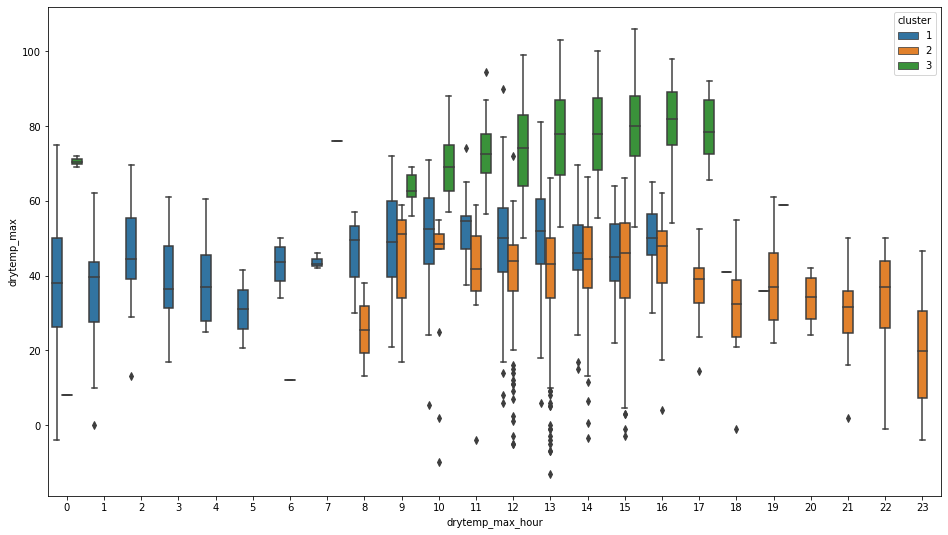

In [22]:
plt.figure(figsize = (16,9))
sb.boxplot(x = "drytemp_max_hour", y = 'drytemp_max', data = bilDaily, hue = "cluster")

In [23]:
bilDailyGroup = bilDaily.groupby("cluster")

In [24]:
bilDailyGroup.get_group(1).describe()

,tilt_season,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,pres_max,pres_min,wspd_max,...,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,prec_max_hour,pres_max_hour,pres_min_hour,pres_tend,cluster,month
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,...,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.0,714.000000
mean,2.225490,44.934174,30.219187,26.288515,32.771709,85.210785,51.260506,892.590332,884.299011,20.882353,...,177.308121,0.084181,7.707283,19.221289,6.714286,15.634454,5.490196,5.777311,1.0,6.509804
std,1.233415,15.436175,14.380184,12.988216,12.787605,12.668888,19.579668,6.151130,6.274228,7.217335,...,79.971527,0.160748,5.877408,5.963780,7.805823,7.981886,7.369856,7.304021,0.0,4.118925
min,1.000000,-4.000000,-17.000000,-17.000000,-12.000000,39.500000,8.000000,872.000000,864.000000,7.500000,...,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000,1.0,1.000000
25%,1.000000,36.000000,22.000000,18.000000,26.000000,78.000000,35.625000,888.500000,880.000000,16.000000,...,110.000000,0.000000,0.000000,20.000000,0.000000,9.000000,0.000000,3.000000,1.0,3.000000
50%,2.000000,46.000000,32.000000,25.500000,34.000000,89.000000,51.000000,892.000000,885.000000,20.000000,...,185.500000,0.015000,10.000000,22.000000,3.000000,20.000000,1.000000,7.000000,1.0,5.000000
75%,4.000000,55.875000,40.000000,34.000000,41.000000,93.500000,67.000000,897.000000,889.000000,24.500000,...,245.000000,0.100000,13.000000,23.000000,13.000000,22.000000,12.000000,10.000000,1.0,11.000000
max,4.000000,90.000000,63.500000,58.000000,63.000000,100.000000,93.000000,914.000000,906.000000,51.000000,...,326.000000,1.170000,19.000000,23.000000,23.000000,23.000000,23.000000,24.000000,1.0,12.000000


In [25]:
bilDailyGroup.get_group(2).describe()

,tilt_season,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,pres_max,pres_min,wspd_max,...,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,prec_max_hour,pres_max_hour,pres_min_hour,pres_tend,cluster,month
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,...,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.0,1238.000000
mean,2.008885,40.865509,23.461227,18.640549,27.015347,79.119545,44.608643,895.770569,889.374817,19.231422,...,194.642166,0.009778,14.370759,4.445073,1.600969,7.268982,12.549273,-2.358643,2.0,5.859451
std,1.199199,14.311128,12.731385,11.075932,11.282674,13.453085,16.642641,5.671297,6.176113,6.613871,...,63.668522,0.032675,2.571032,4.406191,4.699101,8.129978,8.900714,6.951542,0.0,4.333467
min,1.000000,-13.000000,-22.000000,-23.000000,-18.000000,37.000000,12.000000,876.000000,867.000000,5.000000,...,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-25.000000,2.0,1.000000
25%,1.000000,33.000000,18.000000,13.000000,22.000000,69.000000,31.000000,892.000000,886.000000,14.000000,...,154.000000,0.000000,13.000000,1.000000,0.000000,0.000000,2.000000,-7.000000,2.0,2.000000
50%,2.000000,43.000000,27.000000,19.500000,29.000000,81.000000,43.000000,896.000000,890.000000,18.000000,...,221.500000,0.000000,14.000000,4.000000,0.000000,6.000000,14.000000,-4.000000,2.0,4.000000
75%,2.000000,51.000000,32.000000,26.000000,34.000000,90.000000,56.000000,900.000000,893.000000,24.000000,...,238.000000,0.000000,15.000000,6.000000,0.000000,10.000000,21.000000,4.000000,2.0,11.000000
max,4.000000,72.000000,50.000000,51.000000,51.000000,100.000000,92.000000,917.500000,906.000000,46.000000,...,312.000000,0.390000,23.000000,23.000000,23.000000,23.000000,23.000000,18.000000,2.0,12.000000


In [26]:
bilDailyGroup.get_group(3).describe()

,tilt_season,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,pres_max,pres_min,wspd_max,...,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,prec_max_hour,pres_max_hour,pres_min_hour,pres_tend,cluster,month
count,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,...,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.0,1701.000000
mean,2.978836,78.365082,53.170193,39.807171,51.883598,66.252205,23.988831,893.524414,888.317749,18.050852,...,184.188126,0.009835,14.088771,5.291005,2.148148,8.009406,12.401529,-1.553792,3.0,7.009994
std,0.740921,11.213022,8.952763,9.356421,7.111423,15.800344,10.116995,4.188019,4.872910,6.005136,...,53.085739,0.039734,1.460378,5.207289,5.752476,8.190089,7.896565,5.618055,0.0,2.054669
min,1.000000,50.000000,29.000000,3.000000,32.000000,20.000000,4.500000,877.000000,867.000000,7.000000,...,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-18.000000,3.0,1.000000
25%,3.000000,69.000000,46.000000,33.000000,47.000000,55.000000,17.000000,891.000000,886.000000,14.000000,...,148.000000,0.000000,13.000000,3.000000,0.000000,0.000000,2.000000,-5.000000,3.0,6.000000
50%,3.000000,79.000000,54.000000,41.000000,53.000000,66.500000,23.000000,894.000000,889.000000,17.000000,...,185.000000,0.000000,15.000000,4.000000,0.000000,6.000000,15.000000,-3.000000,3.0,7.000000
75%,3.000000,88.000000,60.000000,47.000000,58.000000,79.000000,30.000000,896.000000,892.000000,22.000000,...,228.000000,0.000000,15.000000,5.000000,0.000000,13.000000,17.000000,3.000000,3.0,9.000000
max,4.000000,106.000000,76.000000,62.000000,68.000000,100.000000,75.000000,909.000000,901.500000,46.000000,...,328.000000,0.490000,19.000000,23.000000,23.000000,23.000000,23.000000,16.000000,3.0,12.000000
